# Wrangle 
Data Acquisition + Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from wrangle import prep_fitbit, split_fitbit, visualize_split

In [2]:
# wrangled data 
df = prep_fitbit()

In [3]:
# drop categorical columns (only useful for visuals)
df.drop(columns=['month', 'weekday'], inplace=True)

In [4]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2.0,1347,93.0,0.0,0.0,566
2018-04-27,3649,9971,4.70,19.0,1158,219.0,46.0,17.0,1752
2018-04-28,3379,3521,1.66,2.0,702,155.0,22.0,11.0,1124
2018-04-29,2851,1639,0.77,0.0,891,122.0,0.0,0.0,602
2018-04-30,2825,1323,0.62,0.0,880,104.0,0.0,0.0,540


In [5]:
# split data into train 50% validate 30% test 20%
train, validate, test = split_fitbit(df)

---
# Modeling
> Forecasting: Predict the next two weeks of activity from 12/07/18 - 12/21/18

In [6]:
from model import evaluate, plot_and_eval, append_eval_df

In [7]:
# Create the empty dataframe for evaluation purposes
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

## Single Value Models
---
### Last Observed Value
The simplest method for forecasting is to predict all future values to be the last observed value.

#### Make Predictions
- use the model to predict on validate data

In [57]:
# store Last Obsevered Value in a dictionary. Keys are target variables
# values are the Last Obsevered Value.
d = {}
for col in train.columns:
    if type(col) == 'int':
        d[col] = train[col][-1:][0]
        print(col)
    else:
        d[col] = round(train[col][-1:][0],2)
        print(col)

calories_burned
steps
distance
floors
minutes_sedentary
minutes_lightly_active
minutes_fairly_active
minutes_very_active
activity_calories


In [9]:
# print dictionary
d

{'calories_burned': 4079,
 'steps': 12259,
 'distance': 5.78,
 'floors': 8.0,
 'minutes_sedentary': 704,
 'minutes_lightly_active': 213.0,
 'minutes_fairly_active': 23.0,
 'minutes_very_active': 56.0,
 'activity_calories': 2158}

In [10]:
# yhat_df is the data frame that contains the predictions on 
# the validate dataset
def make_predictions(d, validate):
    yhat_df = pd.DataFrame(d, 
                       index = validate.index)
    return yhat_df

yhat_df = make_predictions(d, validate)

yhat_df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,4079,12259,5.78,8.0,704,213.0,23.0,56.0,2158
2018-08-17,4079,12259,5.78,8.0,704,213.0,23.0,56.0,2158


#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 921


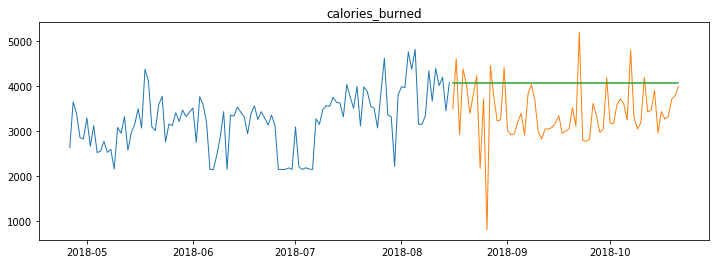

steps -- RMSE: 5156


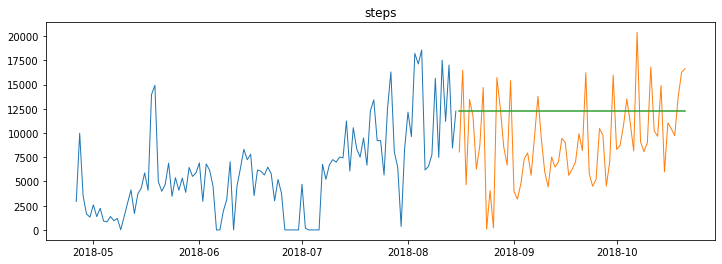

distance -- RMSE: 2


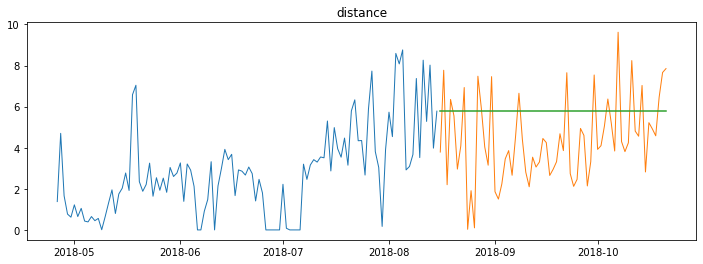

floors -- RMSE: 31


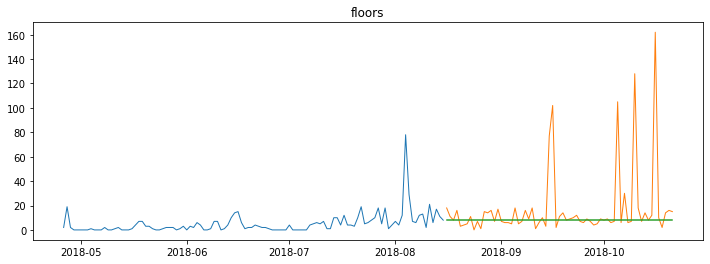

minutes_sedentary -- RMSE: 163


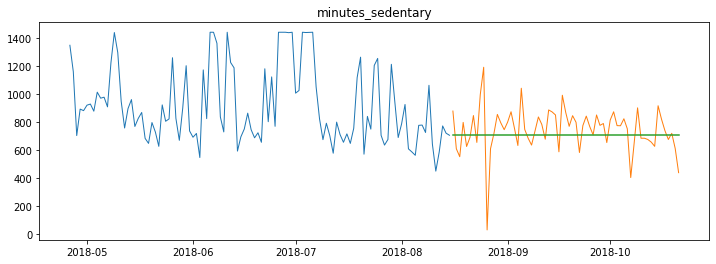

minutes_lightly_active -- RMSE: 64


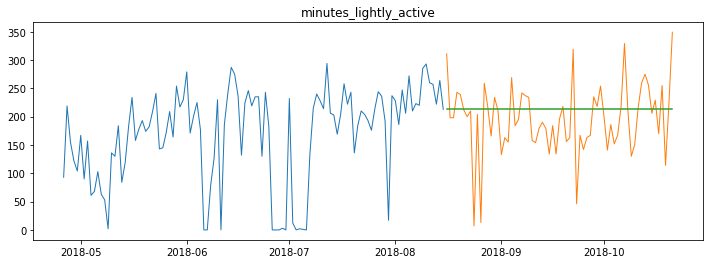

minutes_fairly_active -- RMSE: 18


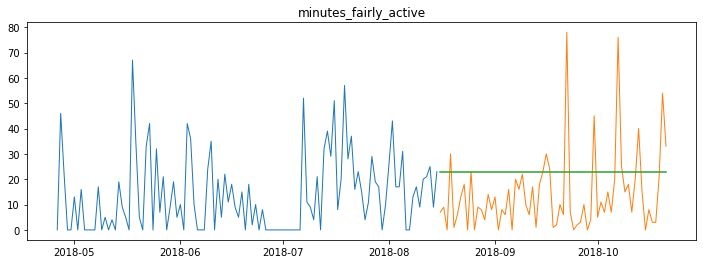

minutes_very_active -- RMSE: 38


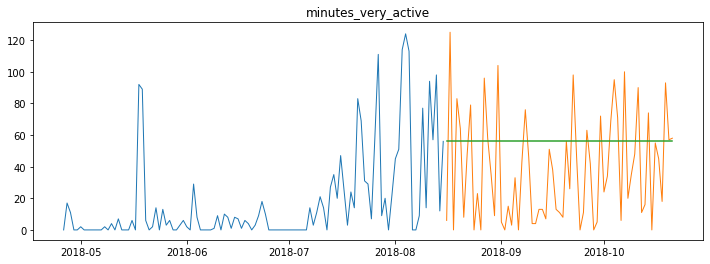

activity_calories -- RMSE: 897


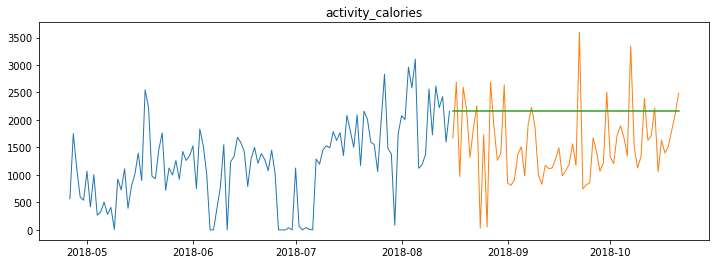

In [11]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [12]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = 'last_observed_value', 
                             target_var = col)

In [13]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0


---
### Simple Average
Take the simple average of historical values and use that value to predict future values.

*This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.*

#### Make Predictions

In [14]:
# store Simple Average in a dictionary. Keys are target variables
# values are the Simple Average.

d = {}
for col in train.columns:
    d[col] = round(train[col].mean(),2)

In [15]:
yhat_df = make_predictions(d, validate)
yhat_df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98
2018-08-17,3246.8,5962.52,2.81,5.18,916.93,168.45,13.78,17.66,1212.98


#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 658


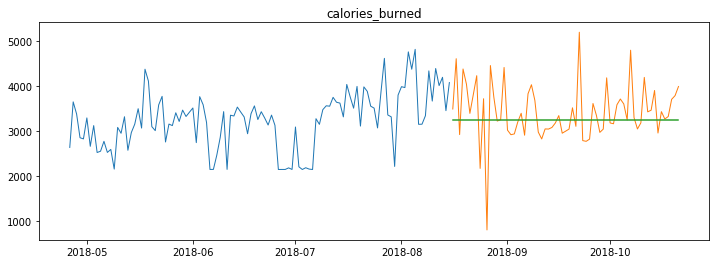

steps -- RMSE: 5356


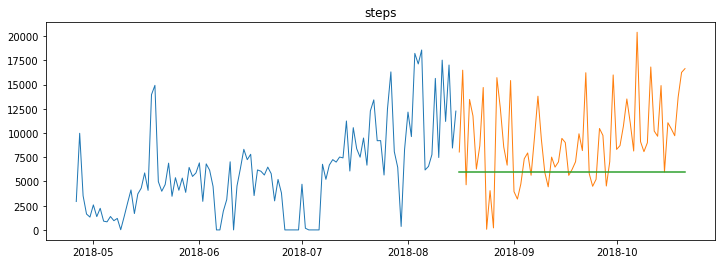

distance -- RMSE: 3


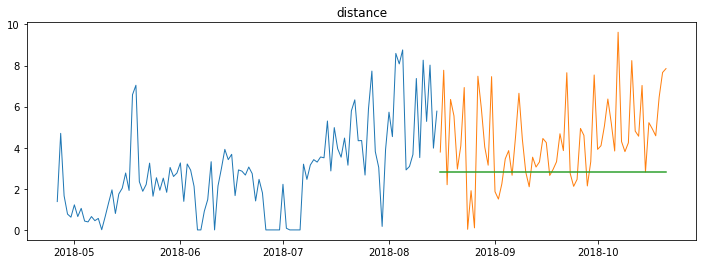

floors -- RMSE: 32


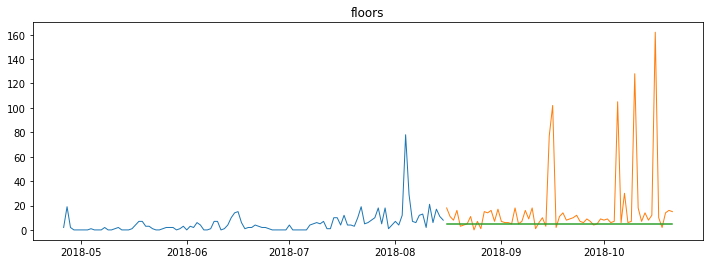

minutes_sedentary -- RMSE: 233


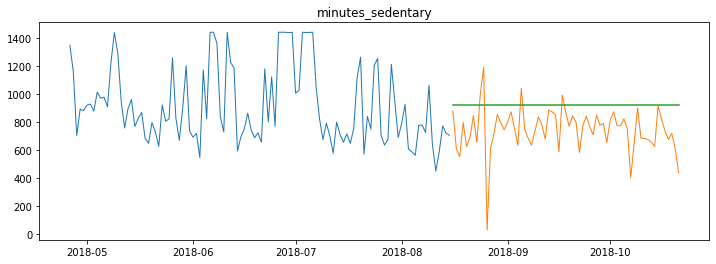

minutes_lightly_active -- RMSE: 68


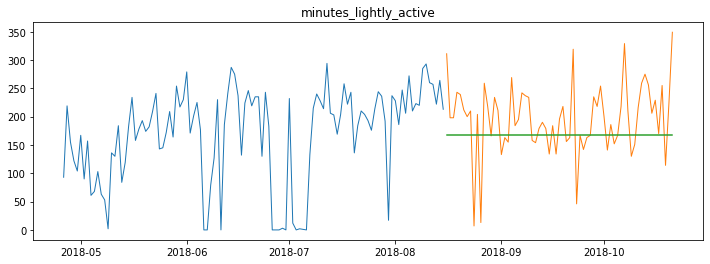

minutes_fairly_active -- RMSE: 16


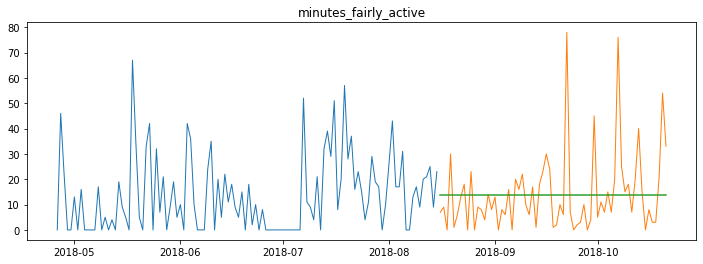

minutes_very_active -- RMSE: 39


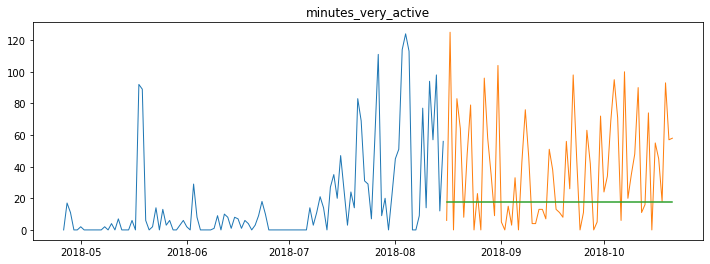

activity_calories -- RMSE: 746


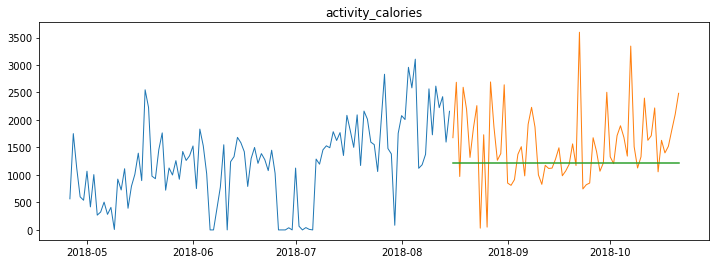

In [16]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [17]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = 'simple_average', 
                             target_var = col)

In [18]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0
9,simple_average,calories_burned,658.0


---
### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

#### Make Predictions

In [19]:
# store 30 day Moving Average 
# compute a 30 day rolling average, in a dictionary. 
# Keys are target variables
# values are the 30 day Moving Average. 

period = 30

d = {}
for col in train.columns:
    d[col] = round(train[col].rolling(period).mean().iloc[-1], 2)

In [20]:
yhat_df = make_predictions(d, validate)
yhat_df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-08-16,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-17,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93
2018-08-18,3774.33,10650.63,5.02,12.0,797.2,218.4,18.83,45.63,1872.93


#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 732


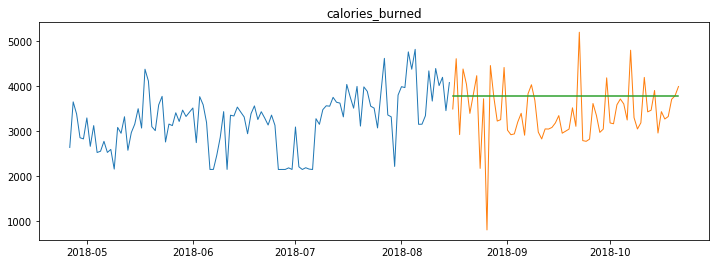

steps -- RMSE: 4425


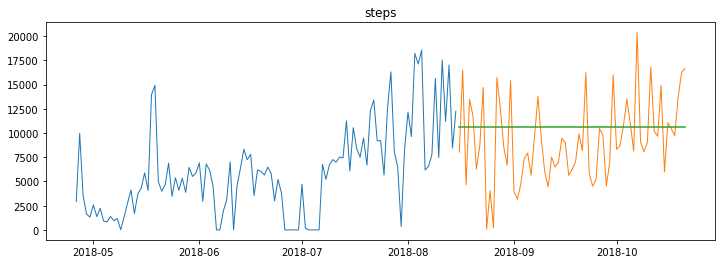

distance -- RMSE: 2


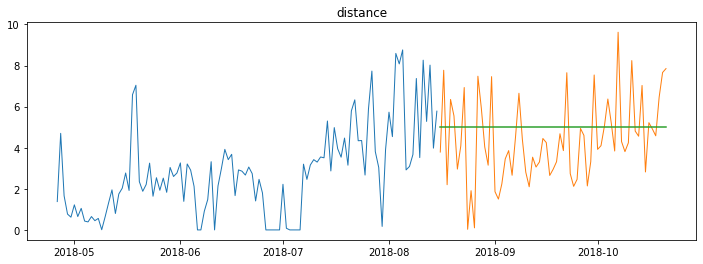

floors -- RMSE: 30


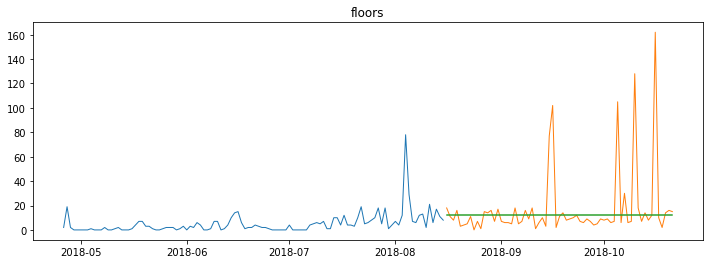

minutes_sedentary -- RMSE: 166


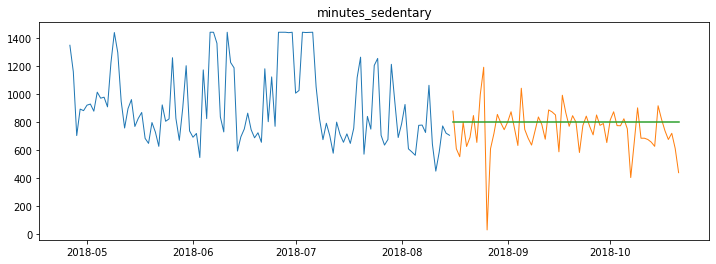

minutes_lightly_active -- RMSE: 66


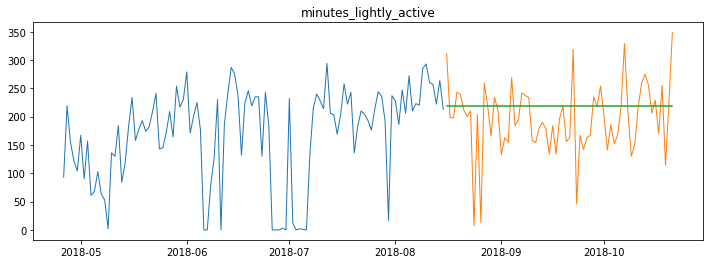

minutes_fairly_active -- RMSE: 16


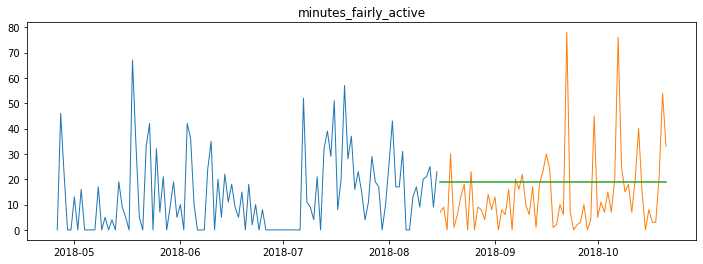

minutes_very_active -- RMSE: 34


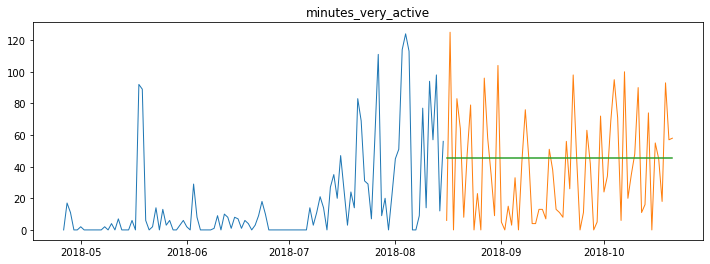

activity_calories -- RMSE: 736


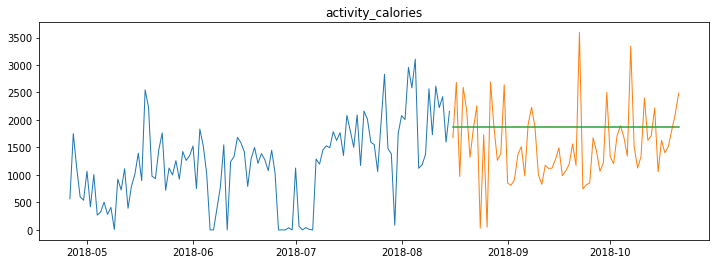

In [21]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [22]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = '30d_moving_avg', 
                             target_var = col)

In [23]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0
9,simple_average,calories_burned,658.0


#### Best so far?

In [24]:
# lowest RMSE for each variable
eval_df.groupby('target_var')['rmse'].min()

target_var
activity_calories          736.0
calories_burned            658.0
distance                     2.0
floors                      30.0
minutes_fairly_active       16.0
minutes_lightly_active      64.0
minutes_sedentary          163.0
minutes_very_active         34.0
steps                     4425.0
Name: rmse, dtype: float64

In [25]:
# filter eval_df where the lowest RMSE from each variable is present
# within the original eval_df up until now
def best_model_feature(eval_df):
    best = eval_df[((eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[0])
              | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[1])
              | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[2])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[3])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[4])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[5])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[6])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[7])
            | (eval_df.rmse == eval_df.groupby('target_var')['rmse'].min()[8]))]
    return best

In [26]:
best = best_model_feature(eval_df)
best

,model_type,target_var,rmse
2,last_observed_value,distance,2.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
9,simple_average,calories_burned,658.0
15,simple_average,minutes_fairly_active,16.0
19,30d_moving_avg,steps,4425.0
20,30d_moving_avg,distance,2.0
21,30d_moving_avg,floors,30.0
24,30d_moving_avg,minutes_fairly_active,16.0
25,30d_moving_avg,minutes_very_active,34.0


Takeaways:
- **Last Observed Value** does best for 
    1. `distance`
    2. `minutes_sedentary`
    3. `minutes_lightly_active`
- **Simple Average** is best for:
    4. `calories_burned`
    5. `minutes_fairly_active`
- **30 Day Moving Avg** is best for:
    6. `steps`
    7. `floors`
    8. `minutes_very_active`
    9. `activity_calories`

## Complex Models
---

### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).

- α / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

#### Seasonal Decomposition

First, let's take a look at the seasonal decomposition for each target.

calories_burned 



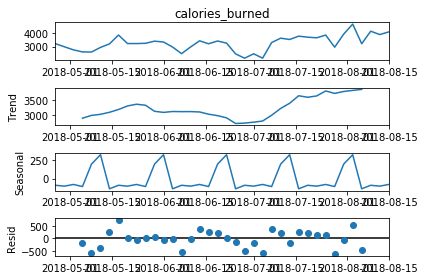

steps 



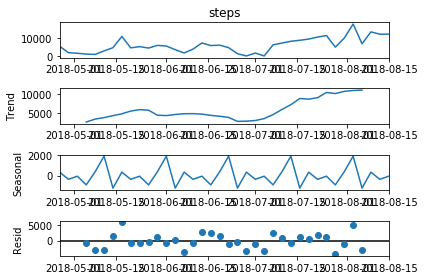

distance 



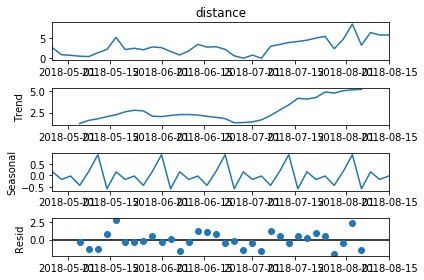

floors 



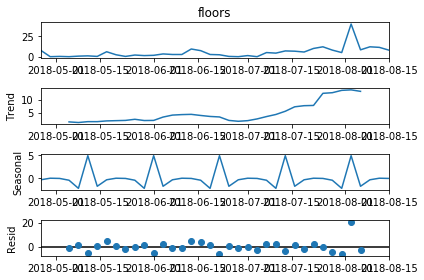

minutes_sedentary 



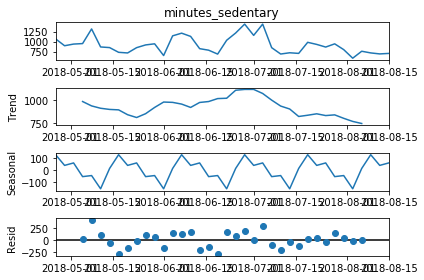

minutes_lightly_active 



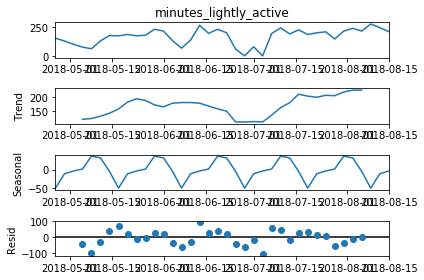

minutes_fairly_active 



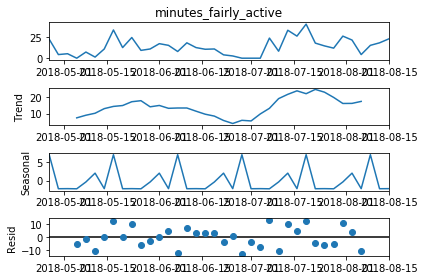

minutes_very_active 



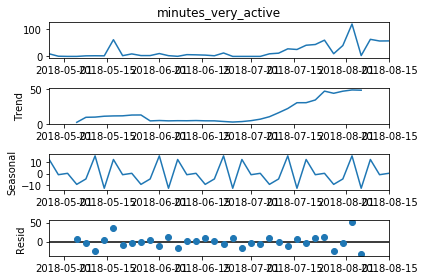

activity_calories 



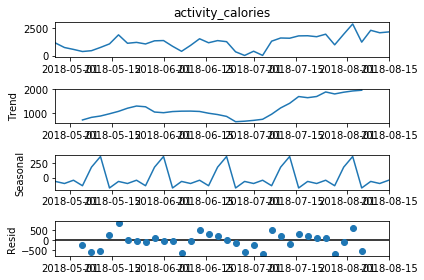

In [27]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3d').mean()).plot()
    plt.show()

#### Make Predictions
Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit:

- smoothing_level (α): value between (0,1)
- smoothing_slope (β): value between (0,1)

In [28]:
for col in train.columns:
    model = Holt(train[col], exponential = False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 775


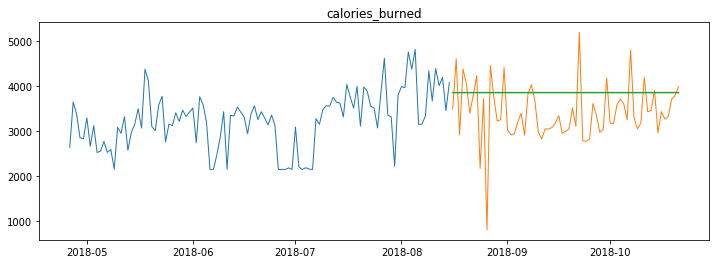

steps -- RMSE: 4716


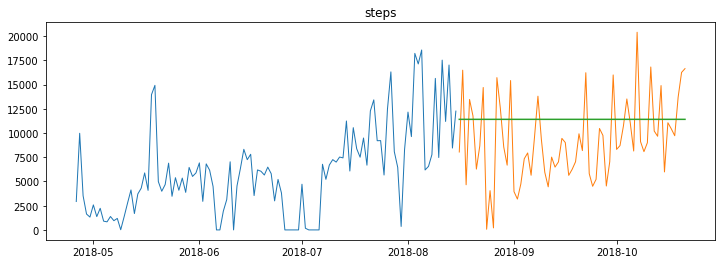

distance -- RMSE: 2


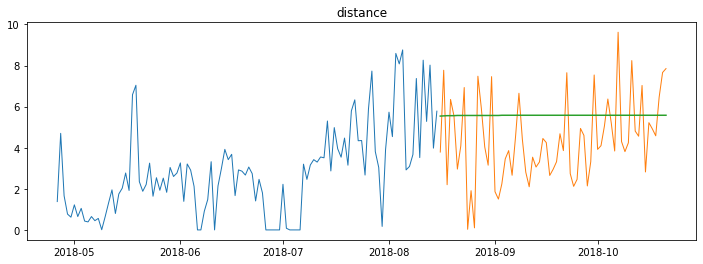

floors -- RMSE: 30


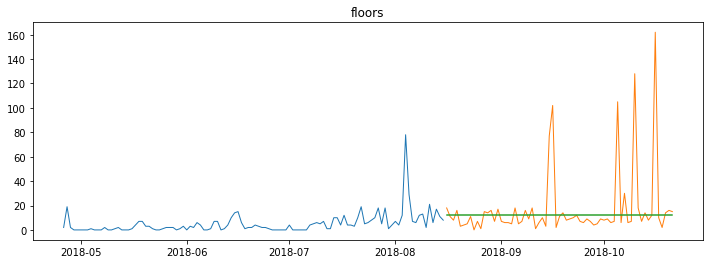

minutes_sedentary -- RMSE: 158


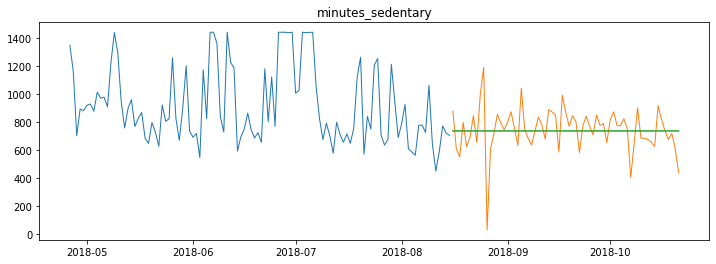

minutes_lightly_active -- RMSE: 72


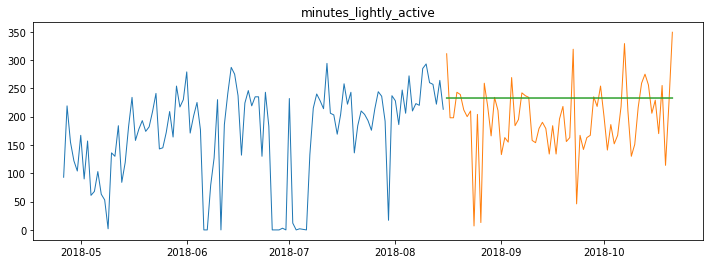

minutes_fairly_active -- RMSE: 16


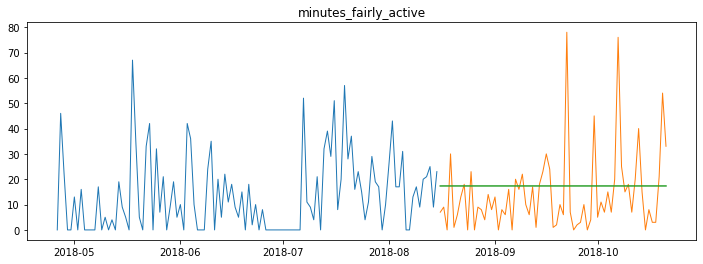

minutes_very_active -- RMSE: 40


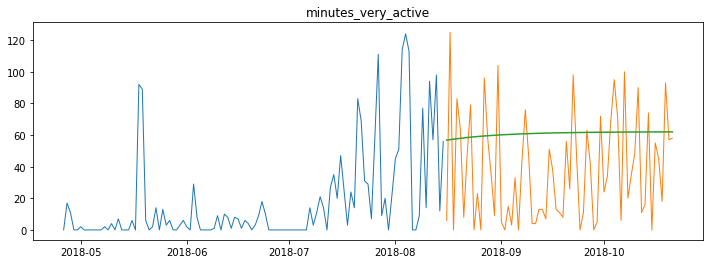

activity_calories -- RMSE: 786


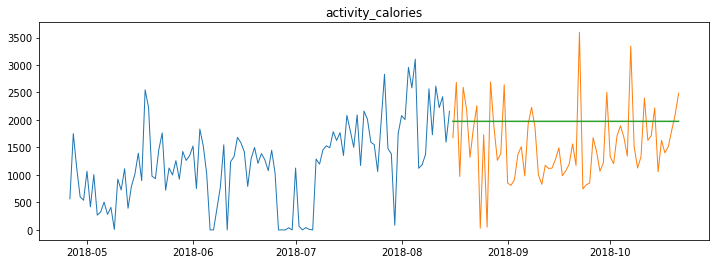

In [29]:
for col in train.columns:
    plot_and_eval(train, validate, yhat_df, target_var = col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [30]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, validate, yhat_df, model_type = 'Holts', 
                             target_var = col)

---
### Previous Cycle

Use a bi-weekly cycle to predict for the next two weeks.

#### Re-split Data

In [31]:
train2 = df.loc[:'2018-11-09']
validate2 = df.loc['2018-11-09':'2018-11-22']
test2 = df.loc['2018-11-23':'2018-12-06']

print(train2.shape)
print(validate2.shape)
print(test2.shape)

(198, 9)
(14, 9)
(14, 9)


#### Make Predictions

In [32]:
yhat_df = train2['2018-10-27':'2018-11-09'] + train2.diff(14).mean()
yhat_df.index = validate2.index

#### Plot Actual vs. Predicted Values
- for each target variable

calories_burned -- RMSE: 543


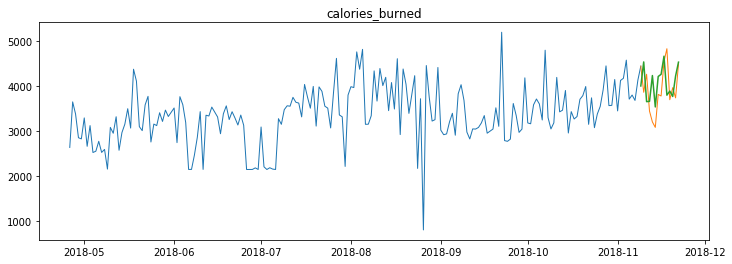

steps -- RMSE: 5640


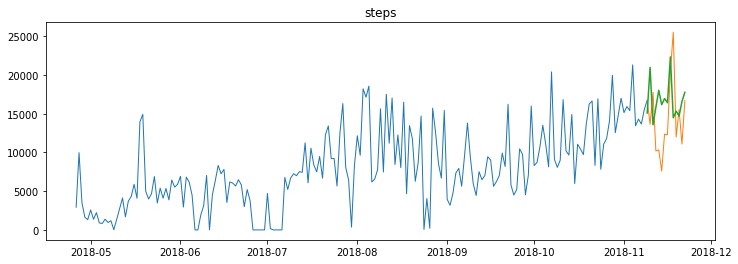

distance -- RMSE: 3


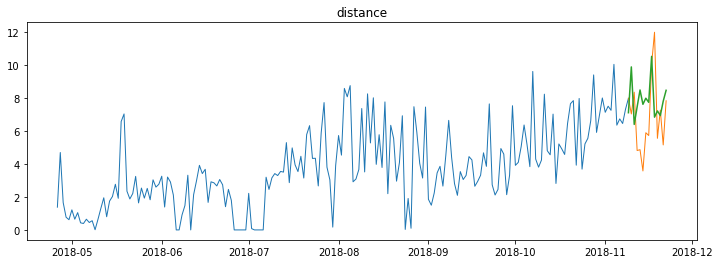

floors -- RMSE: 55


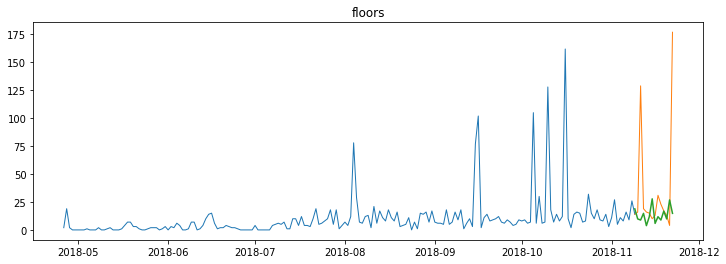

minutes_sedentary -- RMSE: 138


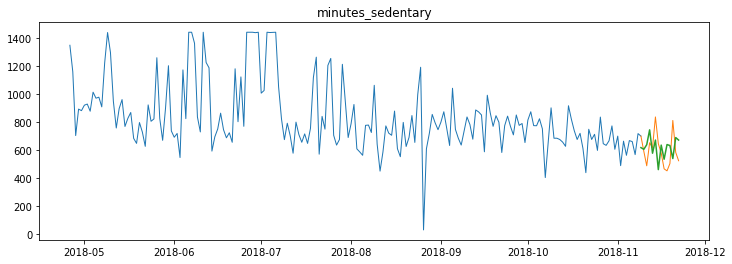

minutes_lightly_active -- RMSE: 74


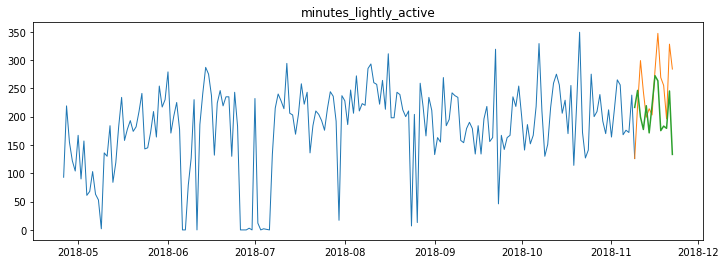

minutes_fairly_active -- RMSE: 23


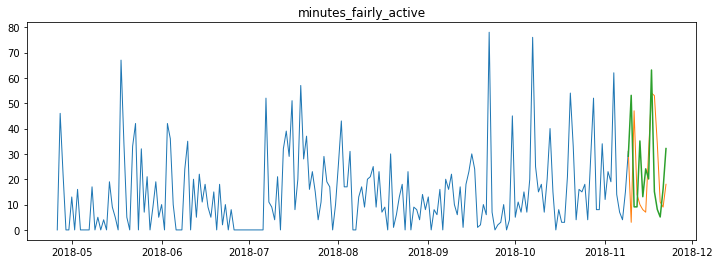

minutes_very_active -- RMSE: 47


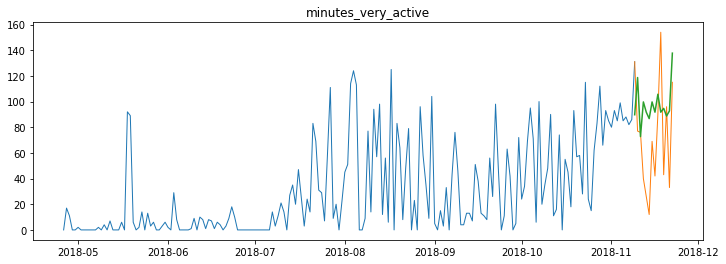

activity_calories -- RMSE: 637


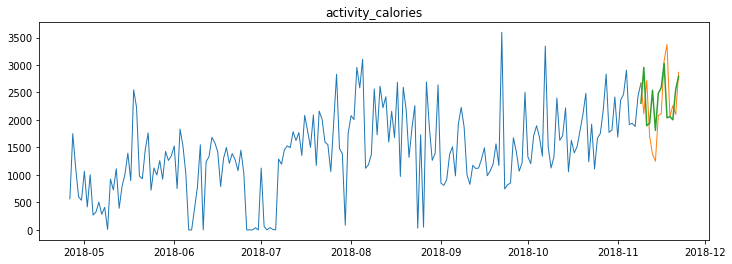

In [33]:
for col in train2.columns:
    plot_and_eval(train2, validate2, yhat_df, target_var = col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that

In [34]:
for col in train2.columns:
    eval_df = append_eval_df(eval_df, validate2, yhat_df, model_type = 'previous_2wks', 
                             target_var = col)

In [35]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,distance,2.0
3,last_observed_value,floors,31.0
4,last_observed_value,minutes_sedentary,163.0
5,last_observed_value,minutes_lightly_active,64.0
6,last_observed_value,minutes_fairly_active,18.0
7,last_observed_value,minutes_very_active,38.0
8,last_observed_value,activity_calories,897.0
9,simple_average,calories_burned,658.0


In [36]:
# Determine which model is best
# This model will move on to 'TEST'
pd.set_option('display.max_rows', None)
final_eval = eval_df.groupby(['target_var', 'model_type'])[['rmse']].min()
final_eval

rmse
target_var             model_type                 
activity_calories      30d_moving_avg        736.0
                       Holts                 786.0
                       last_observed_value   897.0
                       previous_2wks         637.0
                       simple_average        746.0
calories_burned        30d_moving_avg        732.0
                       Holts                 775.0
                       last_observed_value   921.0
                       previous_2wks         543.0
                       simple_average        658.0
distance               30d_moving_avg          2.0
                       Holts                   2.0
                       last_observed_value     2.0
                       previous_2wks           3.0
                       simple_average          3.0
floors                 30d_moving_avg         30.0
                       Holts                  30.0
                       last_observed_value    31.0
                       previous_2wks          55.0
                       simple_average         32.0
minutes_fairly_active  30d_moving_avg         16.0
                       Holts                  16.0
                       last_observed_value    18.0
                       previous_2wks          23.0
                       simple_average         16.0
minutes_lightly_active 30d_moving_avg         66.0
                       Holts                  72.0
                       last_observed_value    64.0
                       previous_2wks          74.0
                       simple_average         68.0
minutes_sedentary      30d_moving_avg        166.0
                       Holts                 158.0
                       last_observed_value   163.0
                       previous_2wks         138.0
                       simple_average        233.0
minutes_very_active    30d_moving_avg         34.0
                       Holts                  40.0
                       last_observed_value    38.0
                       previous_2wks          47.0
                       simple_average         39.0
steps                  30d_moving_avg       4425.0
                       Holts                4716.0
                       last_observed_value  5156.0
                       previous_2wks        5640.0
                       simple_average       5356.0

In [37]:
# compare average rmse amond all target vars
final_eval.groupby('model_type').rmse.mean().sort_values()

model_type
30d_moving_avg         689.666667
Holts                  732.777778
simple_average         794.555556
previous_2wks          795.555556
last_observed_value    810.000000
Name: rmse, dtype: float64

#### Conclusion: 30 day moving average has lowest average RMSE among all target features

---
### Test
- test 30 Day Moving Avg model on out of sample data

#### Resample to combine Train and Validate
- Using to predict on test

In [38]:
train_size = int(len(df)*.8)
test_size = int(len(df) - train_size)

train = df[:train_size]
test = df[train_size:]

train.shape, test.shape

((180, 9), (45, 9))

#### Make Predictions

In [39]:
period = 30

d = {}
for col in train.columns:
    d[col] = round(train[col].rolling(period).mean().iloc[-1], 2)

In [40]:
yhat_df = make_predictions(d, test)
yhat_df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-10-23,3431.73,10466.2,4.95,21.87,729.37,200.07,15.93,42.87,1600.4
2018-10-24,3431.73,10466.2,4.95,21.87,729.37,200.07,15.93,42.87,1600.4
2018-10-25,3431.73,10466.2,4.95,21.87,729.37,200.07,15.93,42.87,1600.4


#### Plot Actual vs. Predicted Values
- for each target variable

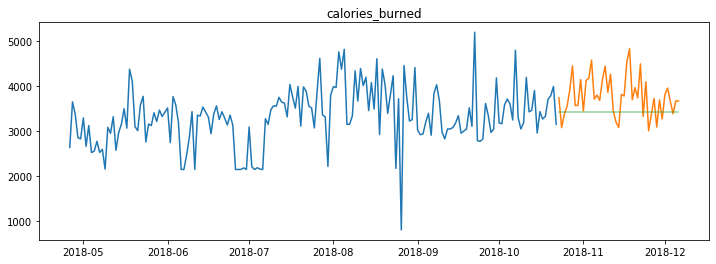

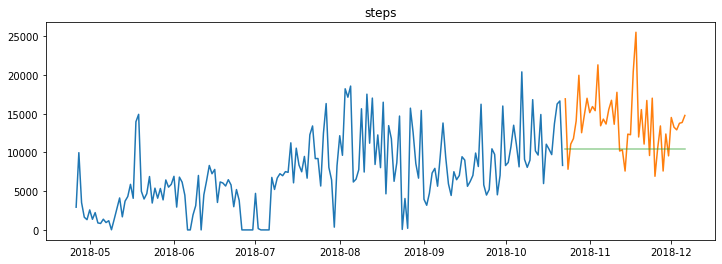

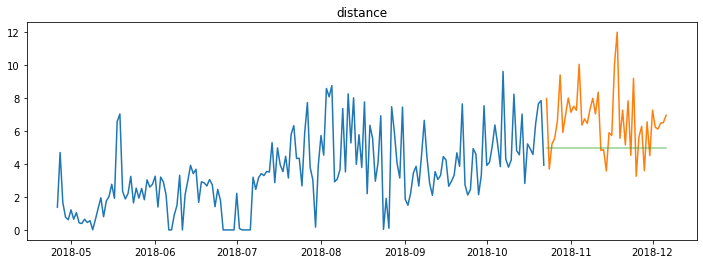

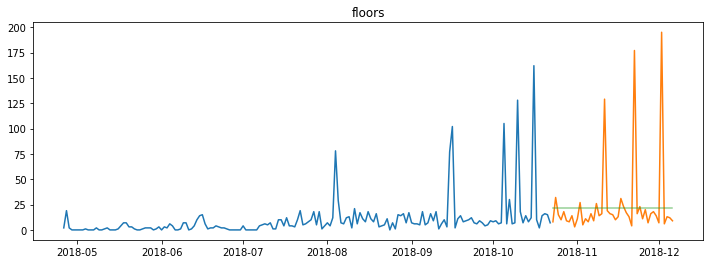

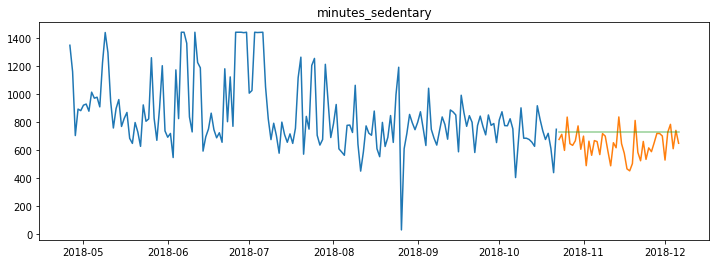

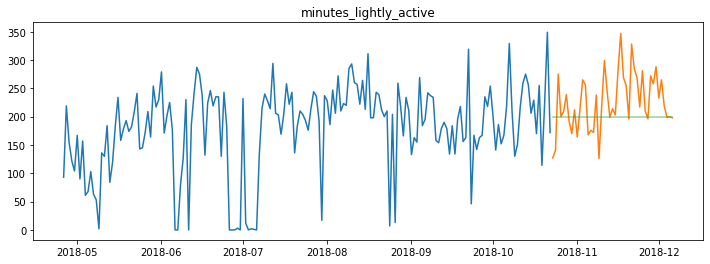

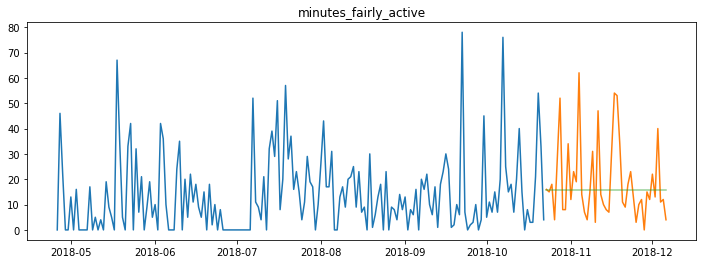

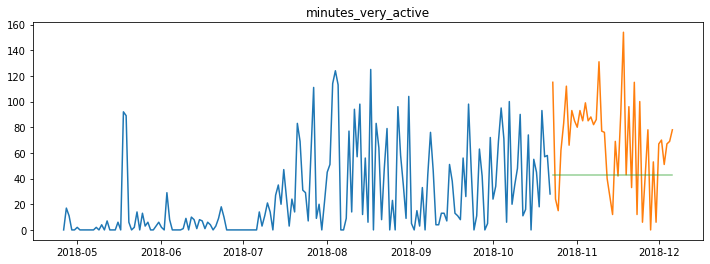

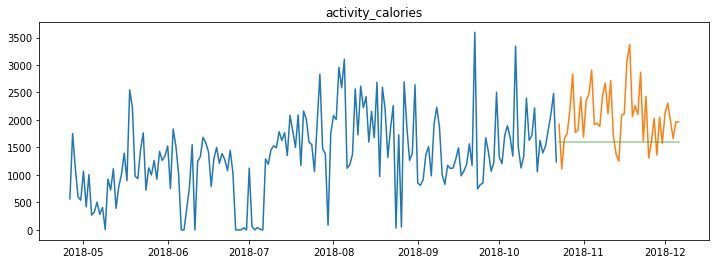

In [41]:
def final_plot(train, test, target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()
    
for col in train.columns:
    final_plot(train, test, col)

### Evaluate
- Evaluate using rmse for each variable in a dataframe that
- We will update with other models

In [42]:
final_eval = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
for col in train.columns:
    final_eval = append_eval_df(final_eval, test, yhat_df, model_type = '30d_moving_avg', 
                             target_var = col)
final_eval

,model_type,target_var,rmse
0,30d_moving_avg,calories_burned,555.0
1,30d_moving_avg,steps,5012.0
2,30d_moving_avg,distance,2.0
3,30d_moving_avg,floors,39.0
4,30d_moving_avg,minutes_sedentary,130.0
5,30d_moving_avg,minutes_lightly_active,56.0
6,30d_moving_avg,minutes_fairly_active,16.0
7,30d_moving_avg,minutes_very_active,43.0
8,30d_moving_avg,activity_calories,676.0


In [43]:
eval_df[eval_df.model_type == '30d_moving_avg']

,model_type,target_var,rmse
18,30d_moving_avg,calories_burned,732.0
19,30d_moving_avg,steps,4425.0
20,30d_moving_avg,distance,2.0
21,30d_moving_avg,floors,30.0
22,30d_moving_avg,minutes_sedentary,166.0
23,30d_moving_avg,minutes_lightly_active,66.0
24,30d_moving_avg,minutes_fairly_active,16.0
25,30d_moving_avg,minutes_very_active,34.0
26,30d_moving_avg,activity_calories,736.0


In [44]:
# Define baseline as last observed value
baseline = pd.DataFrame(eval_df[eval_df.model_type == 'last_observed_value'])

# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
base_error = baseline.rmse.sum()
test_error = final_eval[final_eval.model_type =='30d_moving_avg'].rmse.sum()
difference = (base_error - test_error)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / base_error) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is 10.44%


---
# Predict missing two weeks

In [45]:
df.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-12-02,3957,13257,6.23,195.0,725,265.0,13.0,70.0,2305
2018-12-03,3660,12915,6.12,6.0,782,219.0,40.0,51.0,1993
2018-12-04,3384,13763,6.49,13.0,608,199.0,11.0,67.0,1663
2018-12-05,3670,13865,6.52,12.0,739,200.0,12.0,69.0,1968
2018-12-06,3669,14774,6.96,9.0,647,198.0,4.0,78.0,1962


In [46]:
test.index[-1]

Timestamp('2018-12-06 00:00:00')

In [47]:
# set predictions to be the 30 day rolling avg
period = 30

d = {}
for col in train.columns:
    d[col] = round(train[col].rolling(period).mean().iloc[-1], 2)
yhat_df = make_predictions(d, test)
yhat_df.tail(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-12-04,3431.73,10466.2,4.95,21.87,729.37,200.07,15.93,42.87,1600.4
2018-12-05,3431.73,10466.2,4.95,21.87,729.37,200.07,15.93,42.87,1600.4
2018-12-06,3431.73,10466.2,4.95,21.87,729.37,200.07,15.93,42.87,1600.4


In [51]:
# adding two weeks to the end of test since index
# is sorted by date
yhat_df.index = test.index + pd.Timedelta('2W')

In [54]:
# filtering so that that yhat is exactly 2 weeks after last day in data
yhat_df = yhat_df[-14:]

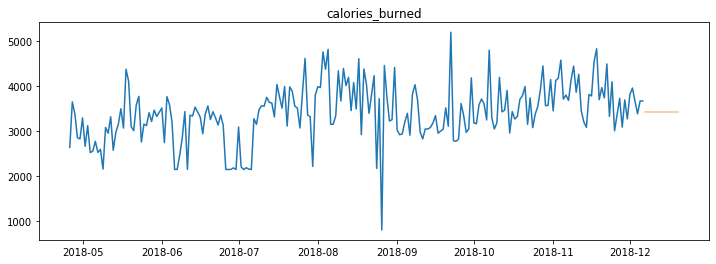

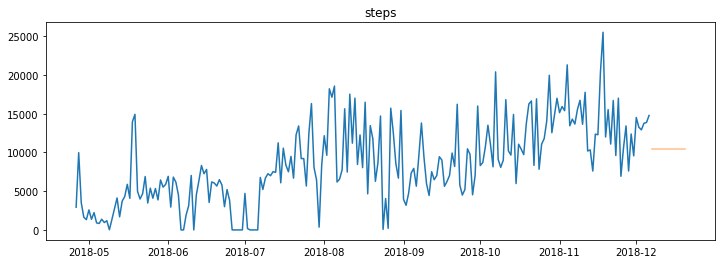

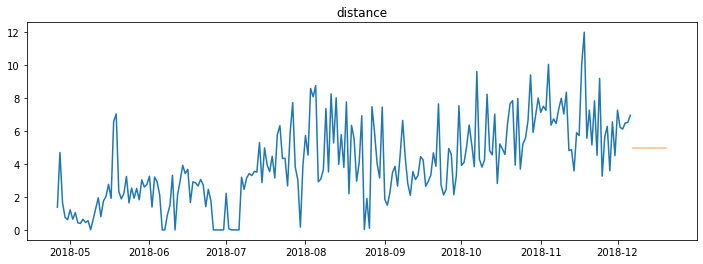

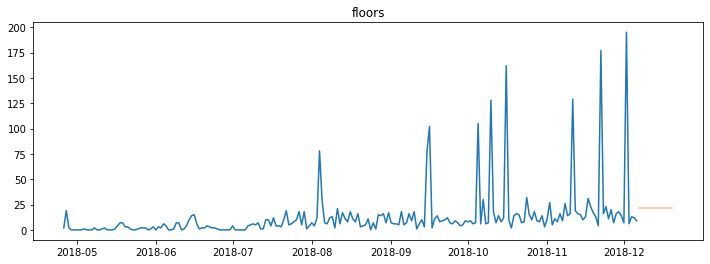

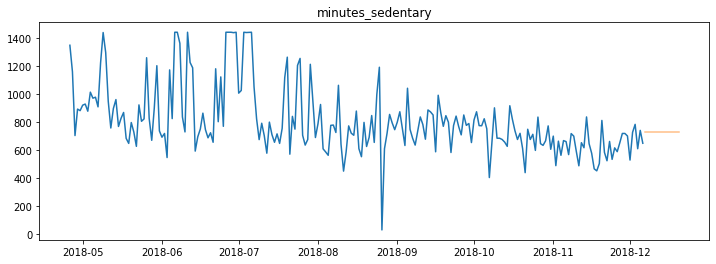

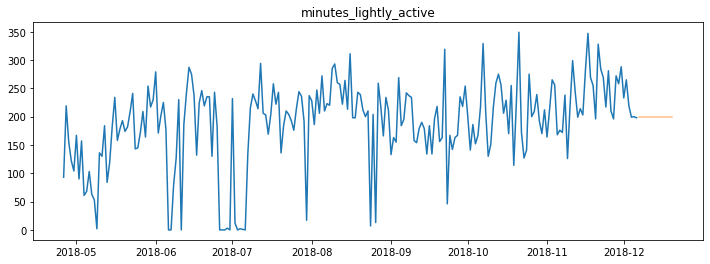

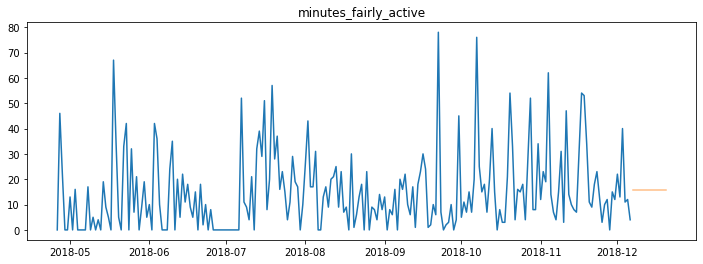

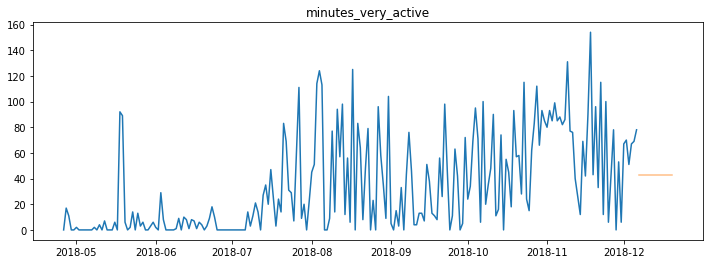

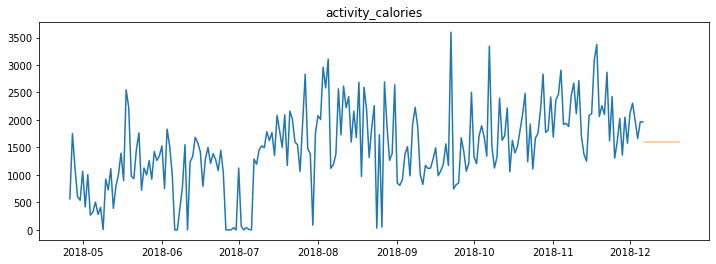

In [55]:
def final_plot(df, yhat_df, target_var):
    plt.figure(figsize=(12,4))
    plt.plot(df[target_var], label='train')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

for col in df.columns:
    final_plot(df, yhat_df, col)

In [56]:
# Create CSV of the next 2 week predictions
# yhat_df.to_csv('predictions_next_2wks.csv')